In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
with open('/kaggle/input/popular-names/names.txt','r') as file:
    data = file.read().split('\n')

In [4]:
data[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
train_data = data[:int(len(data)*0.8)]
val_data = data[int(len(data)*0.8):int(len(data)*0.9)]
test_data = data[int(len(data)*0.9):int(len(data))]

In [6]:
print(len(train_data) , len(val_data) , len(test_data))

25626 3203 3204


**dataset**
*the below function create a dataset given data and chuck size (here a chunck mean how  many char given to predict the next char)*

In [14]:
def makedataset(data,chunck=3):
    x = []
    y = []
    dummy=''
    for i in range(chunck):
        dummy+='.'
    for word in data:
        word = dummy + word + '.'
        for i in range(len(word)-chunck-1):
            x.append(word[i:i+chunck])
            y.append(word[i+chunck])
    return x , y

In [16]:
x , y = makedataset(train_data,3)

**use some type maping to make them into number so that we can do operations on them**

*one way is one hot encodding where echar will be represented by a list of size with vocublary length*
*othre way is we can represent each char into a lower dimensional vector which helps in increasing computaional speed and data requriments*

In [21]:
hashmap = {}
for i , ch in enumerate(range(97,123)):
    hashmap[chr(ch)] = i
hashmap['.']=26
hashmap

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '.': 26}

In [27]:
x_num = []
y_num = []
for i in range(len(x)):
    tmp = []
    for ch in x[i]:
        tmp.append(hashmap[ch])
    y_num.append(hashmap[y[i]])
    x_num.append(tmp)

In [28]:
x_num[0:5]

[[26, 26, 26], [26, 26, 4], [26, 4, 12], [4, 12, 12], [26, 26, 26]]

In [29]:
y_num[0:5]

[4, 12, 12, 0, 14]

In [34]:
x_num = torch.tensor(x_num).to(device)
y_num = torch.tensor(y_num).to(device)

In [36]:
x_num.shape

torch.Size([157152, 3])

**approach**
1. *a trigram laungauge model is a model where it take input of 3 sequence characters and predicts the next char in the sequence*
2. *this can be used as document filling model*
3. *here i will be implementing a trigram model with wavenet architecture*  

In [41]:
encode = nn.Embedding(27,3)
encode.to(device)

Embedding(27, 3)

In [43]:
enc = encode(x_num[0])
enc.shape

torch.Size([3, 3])

*input after will be (3,3) encoded vector out put will be a softmax of dim->(27,1) each giving probs of each char*
*considering batch size input will be (batch_size , 3) -> (batch_size,3,3) -> (batch_size,9) -> *

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        
        
    def forward(self, x):
        
        return x

In [33]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [45]:
class textset(Dataset):
    def __init__(self,x,lookup):
        self.data = x
        self.ground = y
        self.lookup=lookup
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        self.input=self.data[idx]
        self.output=self.ground[idx]
        x = [ord(c) - ord('a') for c in self.input]
        y = [ord(c) - ord('a') for c in self.input]
        return torch.tensor(x) , torch.tensor(y)

In [ ]:
/

TypeError: ord() expected string of length 1, but Tensor found

In [11]:
trigram = Model()

In [12]:
trigram.eval()

Model(
  (enc): Embedding(27, 9)
  (layer1): Linear(in_features=18, out_features=27, bias=True)
  (layer2): Linear(in_features=27, out_features=36, bias=True)
  (layer3): Linear(in_features=36, out_features=27, bias=True)
  (probs): Softmax(dim=1)
)

In [13]:
outputs = trigram(torch.tensor([1,2]))


In [14]:
outputs.shape

torch.Size([1, 27])

In [15]:
from tqdm import tqdm

In [16]:
mp = {'a': 1, 'A': 1, 'b': 2, 'B': 2, 'c': 3, 'C': 3, 'd': 4, 'D': 4, 'e': 5, 'E': 5, 'f': 6, 'F': 6, 'g': 7, 'G': 7, 'h': 8, 'H': 8, 'i': 9, 'I': 9, 'j': 10, 'J': 10, 'k': 11, 'K': 11, 'l': 12, 'L': 12, 'm': 13, 'M': 13, 'n': 14, 'N': 14, 'o': 15, 'O': 15, 'p': 16, 'P': 16, 'q': 17, 'Q': 17, 'r': 18, 'R': 18, 's': 19, 'S': 19, 't': 20, 'T': 20, 'u': 21, 'U': 21, 'v': 22, 'V': 22, 'w': 23, 'W': 23, 'x': 24, 'X': 24, 'y': 25, 'Y': 25, 'z': 26, 'Z': 26}


In [17]:
epochs = 10

In [18]:
import torch.optim as optim

In [19]:
optimizer = optim.Adam(trigram.parameters(), lr=0.01)

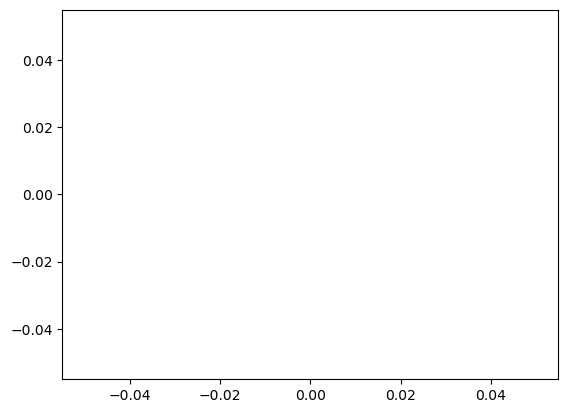

In [20]:
plt.plot()
plt.show()